## CXR Pneumonia Detector

We will train a model to differentiate between Chest X-rays depicting healthy lungs, viral pneumonia and bacterial pneumonia 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
from pathlib import Path

In [4]:
bs = 64

In [5]:
def get_labels(file_path): 
    
    if 'bacteria' in str(file_path):
        return 'bacteria'
    elif 'virus' in str(file_path):
        return 'virus'
    return 'normal'

In [6]:
path = Path('/home/jupyter/tutorials/data/chest_xray/train_val/')

In [7]:
fnames = get_image_files(path)
fnames[:5]

[PosixPath('/home/jupyter/tutorials/data/chest_xray/train_val/person1002_bacteria_2933.jpeg'),
 PosixPath('/home/jupyter/tutorials/data/chest_xray/train_val/person277_virus_571.jpeg'),
 PosixPath('/home/jupyter/tutorials/data/chest_xray/train_val/IM-0712-0001.jpeg'),
 PosixPath('/home/jupyter/tutorials/data/chest_xray/train_val/person348_virus_720.jpeg'),
 PosixPath('/home/jupyter/tutorials/data/chest_xray/train_val/person1198_bacteria_3148.jpeg')]

In [8]:
np.random.seed(2)

In [9]:
data = ImageDataBunch.from_name_func(path, fnames, label_func=get_labels, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)
data.classes

['bacteria', 'normal', 'virus']

In [ ]:
data.show_batch(rows=3, figsize=(7,6))

## Training

In [10]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Let's try training for 4 epochs:

In [12]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.113047,0.813627,0.307839,01:12
1,0.833352,0.608992,0.247610,01:12
2,0.662383,0.525642,0.222753,01:12
3,0.591230,0.510387,0.207457,01:10


Error rate is still improving - let's go for another 6 epochs to make it 10:

In [13]:
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,error_rate,time
0,0.580270,0.539426,0.239006,01:10
1,0.588914,0.512554,0.217973,01:11
2,0.570889,0.526253,0.234226,01:12
3,0.549830,0.491230,0.211281,01:10
4,0.510797,0.467375,0.201721,01:12
5,0.492156,0.467658,0.204589,01:11


In [15]:
learn.save('stage-1')

We seem to be stuck around tthe 80% accuracy mark, let's take a look at our results:

## Results

In [16]:
interp = ClassificationInterpretation.from_learner(learn)

In [17]:
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

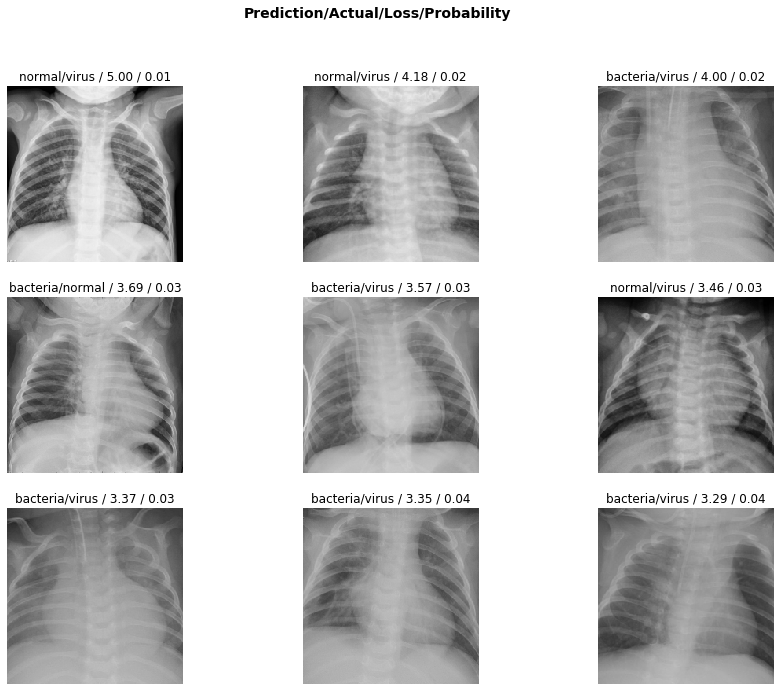

In [18]:
interp.plot_top_losses(9, figsize=(15,11))

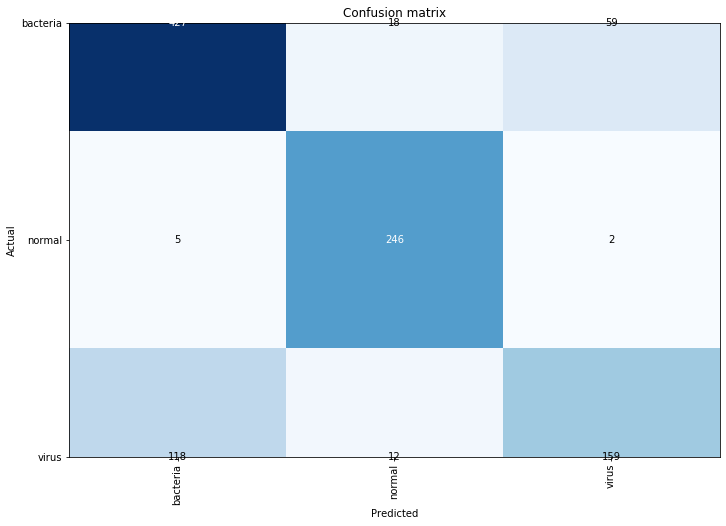

In [25]:
interp.plot_confusion_matrix(figsize=(10,12))

In [20]:
interp.most_confused(min_val=2)

[('virus', 'bacteria', 118),
 ('bacteria', 'virus', 59),
 ('bacteria', 'normal', 18),
 ('virus', 'normal', 12),
 ('normal', 'bacteria', 5),
 ('normal', 'virus', 2)]

It seems like our model is pretty good at being able to tell which lungs are normal and which are not. It rarely mistakes healthy lungs for pneumonic lungs (only 7/253) but does mistake pneumonic lungs for healthy lungs on 30 occasions. This is too many. Furthermore, it is much better at predicting bacterial pneumonia compared to viral pneumonia. Viral pneumonia is often mistaken for bacterial pneumonia (over 40% of the time)

#### Model unfreezing and further training

Since our model is performing reasonably well, let's try unfreezing it and actually training some of the earlier layers. Let's first experiment with learning rates:

In [11]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (4186 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bacteria,virus,normal,bacteria,bacteria
Path: /home/jupyter/tutorials/data/chest_xray/train_val;

Valid: LabelList (1046 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal,bacteria,bacteria,bacteria,virus
Path: /home/jupyter/tutorials/data/chest_xray/train_val;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


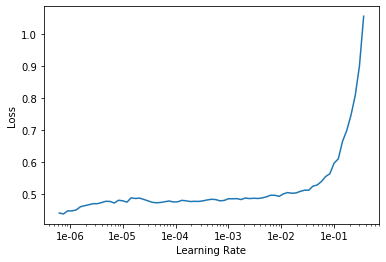

In [21]:
learn.recorder.plot()

In [12]:
learn.unfreeze()
learn.fit_one_cycle(6, max_lr=slice(1e-6,1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,0.512814,0.546173,0.210325,01:13
1,0.548083,0.686591,0.227533,01:10
2,0.522238,0.543293,0.225621,01:09
3,0.463623,0.440892,0.190249,01:09
4,0.402628,0.423858,0.179732,01:09
5,0.357622,0.432043,0.182600,01:09


Seems like our error rate just keeps improving!

In [13]:
learn.save('stage-2')

All done!